# Project 7 - Event Driven Finance

## Problem 1

The takeover deals we will study are -

(1) [United Techologies' (UTX) acquisition of Goodrich Corporation (GR)](http://www.utc.com/News/News-Center/Pages/United-Technologies-To-Acquire-Goodrich-Corporation-Complements-And-Strengthens.aspx) for $18.4bn in cash - announced September 21, 2011

(2) [Procter and Gamble's (PG) acquisition of Gillette (G)](http://www.wsj.com/articles/SB110687225259838788) for $54bn in stock - announced January 28, 2005

We now proceed to study the implied volatilities of the 40/50 dealta front month and 30 delta back month options series around the temporal boundaries of the deal announcement dates.

## Problem 2

In [1]:
import sys
sys.path.append('../utils/')

from query import query_dataframe_f, pprint_query, nbprint_and_query
use_latex = False

In [95]:
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from numpy import log, exp, sqrt, abs
import numpy as np

def black_scholes(S, K, T, r, sigma, is_call):
    def d1(S, K, T, r, sigma):
        return (1./(sigma * sqrt(T)) *
                (log(S / K) +
                 (r + sigma**2 / 2)*T)
               )
    
    def d2(S, K, T, r, sigma):
        return d1(S, K, T, r, sigma) - sigma * sqrt(T)
    
    _d1 = d1(S, K, T, r, sigma)
    _d2 = d2(S, K, T, r, sigma)
    if is_call:
        return norm.cdf(_d1) * S - norm.cdf(_d2) * K * exp(-r * T)
    else:
        return norm.cdf(-_d2) * K * exp(-r * T) - norm.cdf(-_d1) * S
        

def iv_solver(mbbo_price, stock_price, strike,
              expiration_days, rate, is_call):
    cost = lambda vol: abs(mbbo_price - 
                           black_scholes(stock_price,
                                         strike,
                                         expiration_days,
                                         rate,
                                         vol,
                                         is_call))
    res = minimize(cost, .6, method='BFGS')
    return res.x
    

def delta_interpolate(delta, group):
    # Given a row of data and a delta value we want to find
    # (i.e. 50 delta) get the interpolated strike/price of an option,
    # then use that to back out the implied volatility.
    # Note: We assume a European exercise for simplicity
    
    # Since we're using a linear interpolation, we don't need to
    # worry about only getting the rows surrounding the delta we're
    # looking for.
    delta_col = 'IVInterp_{}'.format(delta)
    try:
        is_call = group['CallPut'].values[0] == 'C'
    except KeyError:
        print(group['CallPut'].values)
        group[delta_col] = np.array([np.nan]*len(group))
        return group
    if is_call:
        _delta = delta
    else:
        _delta = -delta
        
    #print(group['Delta'], group[['AdjStrike', 'MBBO']])
    
    try:
        f = interp1d(group['Delta'], group[['AdjStrike', 'MBBO']], axis=0)
        delta_strike, delta_price = f(_delta)
    except ValueError:
        # Don't have enough data to interpolate
        group[delta_col] = np.array([np.nan]*len(group))
        return group
    
    interp_sigma = iv_solver(
        delta_price,
        group['ClosePrice'].values[0],
        delta_strike,
        group['TTE_sec'].values[0] / 365,
        group['ZC_Rate'].values[0] / 100,
        is_call
    )
    group[delta_col] = np.array([interp_sigma]*len(group))
    return group   

In [34]:
#reading in GR and G options trade data from 3 months prior to 1 month after the takeover announcement
#we look at the front month and back month options separately for each name

gr_data_front = query_dataframe_f('Q2-GR-Front-new.sql')
gr_data_front['MBBO'] = gr_data_front['BestBid'] / 2 + gr_data_front['BestOffer'] / 2
gr_data_back = query_dataframe_f('Q2-GR-Back_test.sql')
gr_data_back['MBBO'] = gr_data_back['BestBid'] / 2 + gr_data_back['BestOffer'] / 2

g_data_front = query_dataframe_f('Q2-G-Front.sql')
g_data_front['MBBO'] = g_data_front['BestBid'] / 2 + g_data_front['BestOffer'] / 2
g_data_back = query_dataframe_f('Q2-G-Back_test.sql')
g_data_back['MBBO'] = g_data_back['BestBid'] / 2 + g_data_back['BestOffer'] / 2

In [37]:
#getting IVs for the front month 40,50 deltas and back month 30 deltas
#leading up to the takeover announcement and after it

for delta in [.5, .4]:
    gr_data_front = gr_data_front.groupby(['Date', 'CallPut']).apply(
        lambda group: delta_interpolate(delta, group))
        
    g_data_front = g_data_front.groupby(['Date', 'CallPut']).apply(
        lambda group: delta_interpolate(delta, group)
    )
    
for delta in [.3]:
    gr_data_back = gr_data_back.groupby(['Date', 'CallPut']).apply(
        lambda group: delta_interpolate(delta, group))

    g_data_back = g_data_back.groupby(['Date', 'CallPut']).apply(
        lambda group: delta_interpolate(delta, group)
    )

#remove any null values that might result from the interpolation due to insufficient options trades on a day
#this may be reasonably done since insufficient data implies low interest in a particular name on a given day

gr_data_front=gr_data_front[~gr_data_front.isnull().any(axis=1)]
g_data_front=g_data_front[~g_data_front.isnull().any(axis=1)]
g_data_back=g_data_back[~g_data_back.isnull().any(axis=1)]
gr_data_back=gr_data_back[~gr_data_back.isnull().any(axis=1)]


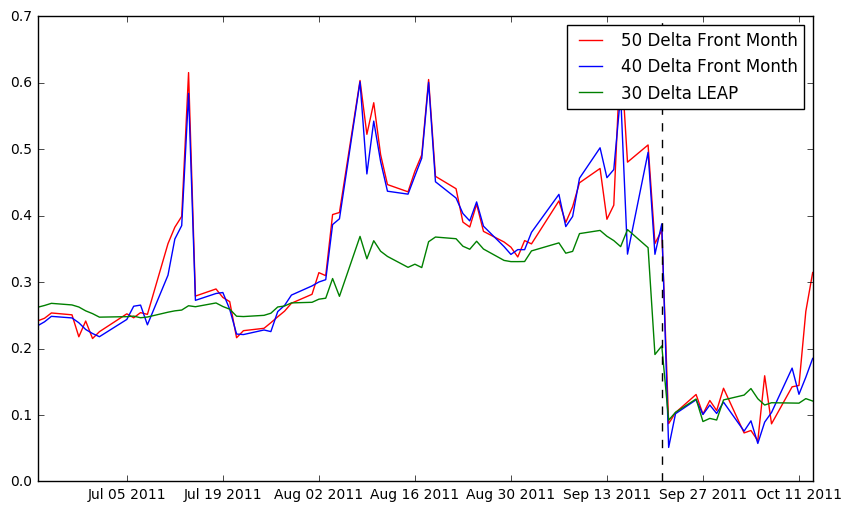

In [38]:
#plot for Goodrich

import matplotlib.pyplot as plt
%matplotlib inline

x=gr_data_front.groupby('Date').mean()['IVInterp_0.5']
y=gr_data_front.groupby('Date').mean()['IVInterp_0.4']
z=gr_data_back.groupby('Date').mean()['IVInterp_0.3']
plt.plot(x,'r', label='50 Delta Front Month') # plotting t,a separately 
plt.plot(y,'b', label='40 Delta Front Month') # plotting t,b separately 
plt.plot(z,'g', label='30 Delta LEAP') # plotting t,c separately 
plt.axvline(x='2011-09-21',color='k',ls='dashed')
legend = plt.legend(loc='upper right', shadow=False)
plt.gcf().set_size_inches(10, 6)
plt.show()



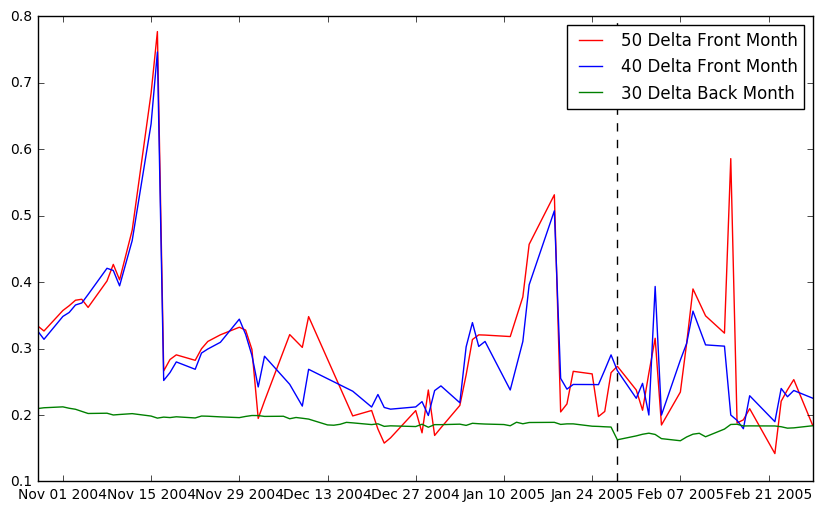

In [39]:
#plot for Gillette

import matplotlib.pyplot as plt
%matplotlib inline

x=g_data_front.groupby('Date').mean()['IVInterp_0.5']
y=g_data_front.groupby('Date').mean()['IVInterp_0.4']
z=g_data_back.groupby('Date').mean()['IVInterp_0.3']
plt.plot(x,'r', label='50 Delta Front Month') # plotting t,a separately 
plt.plot(y,'b', label='40 Delta Front Month') # plotting t,b separately 
plt.plot(z,'g', label='30 Delta Back Month') # plotting t,c separately 
plt.gcf().set_size_inches(10, 6)
legend = plt.legend(loc='upper right', shadow=False)
plt.axvline(x='2005-01-28',color='k',ls='dashed')
plt.show()


Observations:

## Problem 3

In [7]:

from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
def plot_candlestick(values):
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
    dayFormatter = DateFormatter('%d')      # e.g., 12
    
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    ax.xaxis.set_major_locator(mondays)
    ax.xaxis.set_minor_locator(alldays)
    ax.xaxis.set_major_formatter(weekFormatter)
    
    candlestick_ohlc(ax, values, width=1, colorup='g', colordown='r', alpha=0.75)
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    
    plt.grid(True)
    plt.gcf().set_size_inches(10, 6)
    
    return fig, ax

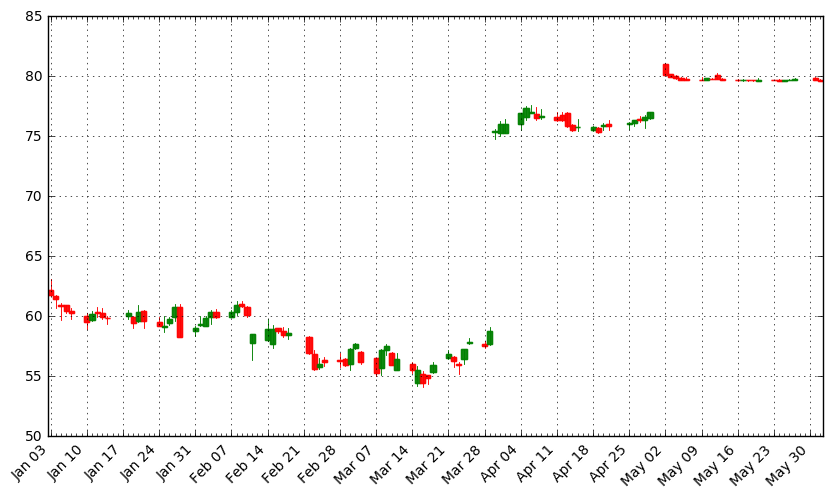

In [8]:
import matplotlib.pyplot as plt
from matplotlib.finance import candlestick_ohlc
from matplotlib.dates import date2num
%matplotlib inline
data = query_dataframe_f('Q3-stock.sql')

# Candlestick plot of Open - High - Low- Close chart
data['date2num'] = data['Date'].apply(date2num)
plot_candlestick(data[['date2num', 'OpenPrice', 'AskHigh', 'BidLow', 'ClosePrice']].values);

There are two events that stick out to us. First, at the end of March, [Valeant launches a hostile takeover bid on Cephalon](http://dealbook.nytimes.com/2011/03/29/valeant-makes-5-7-billion-hostile-bid-for-cephalon/?_r=0), which propels the stock significantly higher. The rejection of the bid propels the stock price up higher than Valeant's bidding price of $73/share, indicating the market's anticipation of a future takeover at an even higher price.

Eventually, at the start of May, [Teva Pharmaceuticals announces that they will acquire Cephalon](http://www.tevapharm.com/news/teva_to_acquire_cephalon_in_6_8_billion_transaction_05_11.aspx) and the stock trades slightly above and around this point for the rest of its listed time.

We will now plot the implied volatilities for the 40- and 50-delta current-expiration options and the 30-delta LEAPs. To get the exact delta, we will interpolate between the prices surrounding a delta value to approximate an exact delta, and do our implied volatility calculations given that data.

In [9]:
# These queries give us the full series for CEPH
# front-month 40- and 50- delta options and 
# the 30- delta LEAPs on a specific date.
# We use the Put and Call options to get an estimate
# for the 30-, 40-, and 50-delta options prices,
# back out the implied vol, then average those volatilities
# for our final answer.
# The interest rates come from the zero-curve rate on that day
# for the maturity closest to expiration.

ceph_front = query_dataframe_f('Q3-CEPH-Front.sql')
ceph_front['MBBO'] = ceph_front['BestBid'] / 2 + ceph_front['BestOffer'] / 2

ceph_back = query_dataframe_f('Q3-CEPH-Back.sql')
ceph_back['MBBO'] = ceph_back['BestBid'] / 2 + ceph_back['BestOffer'] / 2

In [10]:
# These queries give us the full series for CEPH
# front-month 40- and 50- delta options and 
# the 30- delta LEAPs on a specific date.
# We use the Put and Call options to get an estimate
# for the 30-, 40-, and 50-delta options prices,
# back out the implied vol, then average those volatilities
# for our final answer.
# The interest rates come from the zero-curve rate on that day
# for the maturity closest to expiration.

ceph_front = query_dataframe_f('Q3-CEPH-Front.sql')
ceph_front['MBBO'] = ceph_front['BestBid'] / 2 + ceph_front['BestOffer'] / 2

ceph_back = query_dataframe_f('Q3-CEPH-Back.sql')
ceph_back['MBBO'] = ceph_back['BestBid'] / 2 + ceph_back['BestOffer'] / 2

#Calculating front month IVs 

for delta in [.5, .4]:
    ceph_front = ceph_front.groupby(['Date', 'CallPut']).apply(
        lambda group: delta_interpolate(delta, group)
    )
    
#Calculating IVs of the LEAPs  

for delta in [.3]:
    ceph_back = ceph_back.groupby(['Date', 'CallPut']).apply(
        lambda group: delta_interpolate(delta, group)
    )

In [ ]:
import pandas as pd
pd.options.display.max_rows = 999

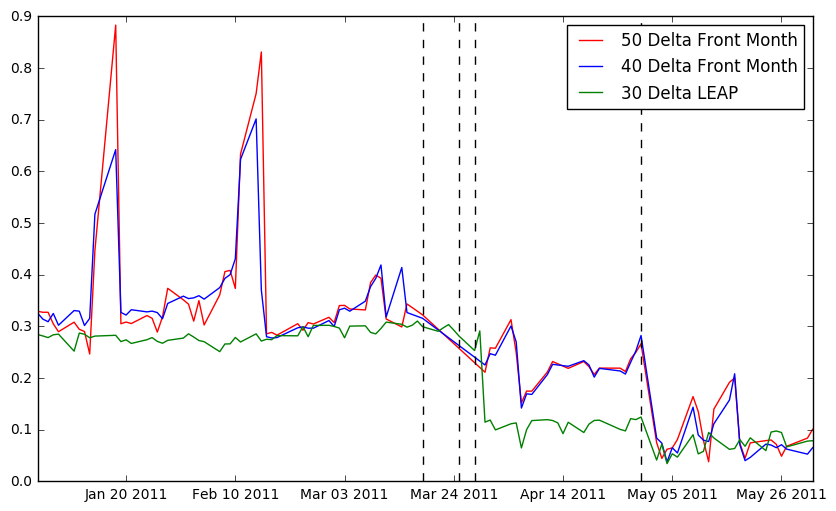

In [21]:
x=ceph_front.groupby('Date').mean()['IVInterp_0.5']
y=ceph_front.groupby('Date').mean()['IVInterp_0.4']
z=ceph_back.groupby('Date').mean()['IVInterp_0.3']
plt.plot(x,'r', label='50 Delta Front Month') 
plt.plot(y,'b', label='40 Delta Front Month')
plt.plot(z,'g', label='30 Delta LEAP')
plt.axvline(x='2011-03-28',color='k',ls='dashed')
plt.axvline(x='2011-04-29',color='k',ls='dashed')
plt.axvline(x='2011-03-18',color='k',ls='dashed')
plt.axvline(x='2011-03-25',color='k',ls='dashed')
legend = plt.legend(loc='upper right', shadow=False)
plt.gcf().set_size_inches(10, 6)
plt.show()

Observations: 

(1) The IV of the 30-delta LEAP crashes after the failed takeover bid by Valeant - this indicates anticipation of a takeover sometime in the future, without a clear timeline. If the timeline was known in advance with any certainty (i.e. if the deal was leaked), we would expect the IV of the ATM front month options to fall below that of the 40-delta front month series (i.e. a pleating) at any point leading up to the actual takeover announcement, which is not the case.

(2) Private bids were launched by Valeant on March 18 and 25 for Cephalon, however there is nothing in the IV plots around these dates to indicate anything was leaked ahead of time.

(3) Surely enough, when Teva Pharmaceuticals announces it will takeover Cephalon in late April, the IV crashes across the board for both front options, and the LEAP IVs fall even further than before, as we would expect, in line with the caricature drawn out in class of how IVs tend to behave around takeover events.

Therefore, while it seems unlikely the Cephalon deal with Teva Pharmaceuticals was leaked beforehand, the market does seem to anticipate such a move as indicated by the LEAP IV crashing, and the stock price being propelled above the  failed bid price lodged by Valeant.

In [ ]:
# Query option data
ceph_data = query_dataframe_f('Q3-options_HI.sql')
# Remove options with no market
ceph_data = ceph_data[ceph_data.HasMarket == 1]

In [ ]:
# Split calls and puts
ceph_data_c = ceph_data[ceph_data.CallPut == 'C']
ceph_data_p = ceph_data[ceph_data.CallPut == 'P']

In [47]:
g_data_front[g_data_front['Date']=='2005-01-28']

,Date,Delta,ClosePrice,AdjStrike,BestBid,BestOffer,Expiration,TTE_sec,CallPut,TTE_zc,ZC_Rate,MBBO,IVInterp_0.5,IVInterp_0.4
331,2005-01-28,0.019137,51.599998,60.0,0.00,0.05,2005-02-19,22,C,3,2.608986,0.025,0.273008,0.277336
332,2005-01-28,0.105656,51.599998,55.0,0.10,0.15,2005-02-19,22,C,3,2.608986,0.125,0.273008,0.277336
333,2005-01-28,0.804342,51.599998,50.0,1.85,1.95,2005-02-19,22,C,3,2.608986,1.900,0.273008,0.277336
334,2005-01-28,-0.890742,51.599998,55.0,3.40,3.60,2005-02-19,22,P,3,2.608986,3.500,0.273869,0.256240
335,2005-01-28,-0.223127,51.599998,50.0,0.25,0.35,2005-02-19,22,P,3,2.608986,0.300,0.273869,0.256240
336,2005-01-28,-0.019102,51.599998,45.0,0.00,0.05,2005-02-19,22,P,3,2.608986,0.025,0.273869,0.256240


In [100]:
g_data_front = query_dataframe_f('Q2-PGN-Front.sql')
g_data_front['MBBO'] = g_data_front['BestBid'] / 2 + g_data_front['BestOffer'] / 2
for delta in [.5, .4]:   
    g_data_front = g_data_front.groupby(['Date', 'CallPut']).apply(
        lambda group: delta_interpolate(delta, group)
    )

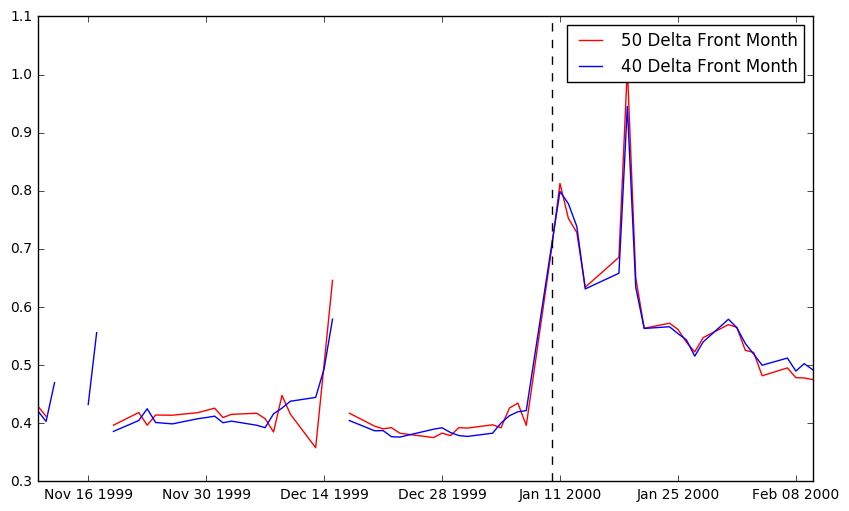

In [101]:
#plot for Gillette

import matplotlib.pyplot as plt
%matplotlib inline

x=g_data_front.groupby('Date').mean()['IVInterp_0.5']
y=g_data_front.groupby('Date').mean()['IVInterp_0.4']
#z=g_data_back.groupby('Date').mean()['IVInterp_0.3']
plt.plot(x,'r', label='50 Delta Front Month') # plotting t,a separately 
plt.plot(y,'b', label='40 Delta Front Month') # plotting t,b separately 
#plt.plot(z,'g', label='30 Delta Back Month') # plotting t,c separately 
plt.gcf().set_size_inches(10, 6)
legend = plt.legend(loc='upper right', shadow=False)
plt.axvline(x='2000-01-10',color='k',ls='dashed')
plt.show()


In [92]:
def iv_solver(mbbo_price, stock_price, strike,
              expiration_days, rate, is_call,iv0):
    cost = lambda vol: abs(mbbo_price - 
                           black_scholes(stock_price,
                                         strike,
                                         expiration_days,
                                         rate,
                                         vol,
                                         is_call))
    res = minimize(cost, iv0, method='BFGS')
    return res.x

def delta_interpolate(delta, group):
    if (len(group) < 2):
        return group
    # Given a row of data and a delta value we want to find
    # (i.e. 50 delta) get the interpolated strike/price of an option,
    # then use that to back out the implied volatility.
    
    delta_col = 'IVInterp_{}'.format(delta)
    try:
        is_call = group['CallPut'].values[0] == 'C'
    except KeyError:
        print(group['CallPut'].values)
        group[delta_col] = np.array([np.nan]*len(group))
        return group
    if is_call:
        _delta = delta
    else:
        _delta = -delta
    
    f = interp1d(group['Delta'], group[['AdjStrike', 'MBBO', 'ImpliedVolatility']], axis=0)

    try:
        delta_strike, delta_price, delta_iv = f(_delta)
    except ValueError:
        #print('Dont have enough data to interpolate')
        group[delta_col] = np.array([np.nan]*len(group))
        return group
    
    steps = 100
    interp_sigma = iv_solver(
        delta_price,
        group['ClosePrice'].values[0],
        delta_strike,
        group['TTE_sec'].values[0] / 365,
        group['ZC_Rate'].values[0] / 100,
        is_call,
        delta_iv
    )
    group[delta_col] = np.array([interp_sigma]*len(group))
    return group    

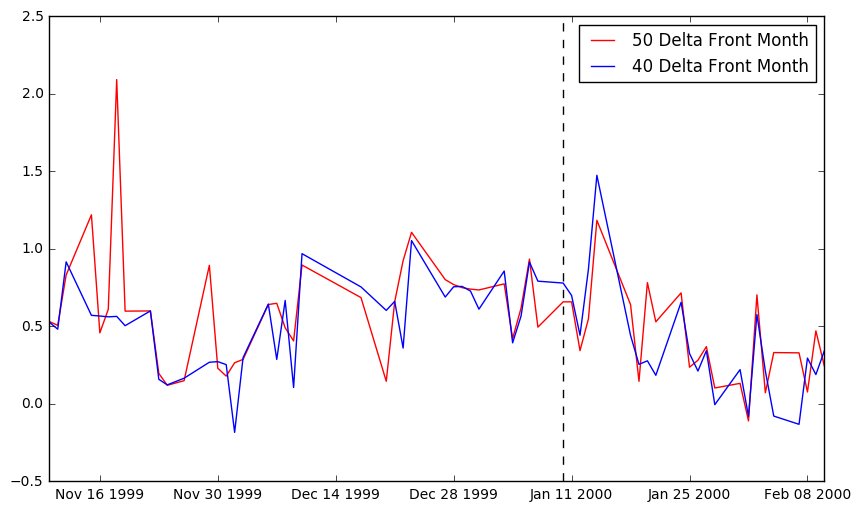

In [97]:
#plot for Gillette

import matplotlib.pyplot as plt
%matplotlib inline

x=g_data_front.groupby('Date').mean()['IVInterp_0.5']
y=g_data_front.groupby('Date').mean()['IVInterp_0.4']
#z=g_data_back.groupby('Date').mean()['IVInterp_0.3']
plt.plot(x,'r', label='50 Delta Front Month') # plotting t,a separately 
plt.plot(y,'b', label='40 Delta Front Month') # plotting t,b separately 
#plt.plot(z,'g', label='30 Delta Back Month') # plotting t,c separately 
plt.gcf().set_size_inches(10, 6)
legend = plt.legend(loc='upper right', shadow=False)
plt.axvline(x='2000-01-10',color='k',ls='dashed')
plt.show()


In [98]:
g_data_front

,Date,Delta,ClosePrice,AdjStrike,BestBid,BestOffer,Expiration,TTE_sec,CallPut,TTE_zc,ZC_Rate,ImpliedVolatility,MBBO,IVInterp_0.5,IVInterp_0.4
0,1999-11-10,0.018723,146.2500,180.0,0.0625,0.1250,1999-11-20,10,C,1,5.420789,0.617191,0.09375,0.452960,0.456568
1,1999-11-10,0.039107,146.2500,175.0,0.1875,0.2500,1999-11-20,10,C,1,5.420789,0.626724,0.21875,0.452960,0.456568
2,1999-11-10,0.052645,146.2500,170.0,0.2500,0.3125,1999-11-20,10,C,1,5.420789,0.570652,0.28125,0.452960,0.456568
3,1999-11-10,0.081740,146.2500,165.0,0.4375,0.4375,1999-11-20,10,C,1,5.420789,0.529383,0.43750,0.452960,0.456568
4,1999-11-10,0.141634,146.2500,160.0,0.7500,0.8750,1999-11-20,10,C,1,5.420789,0.506482,0.81250,0.452960,0.456568
5,1999-11-10,0.238760,146.2500,155.0,1.5000,1.5000,1999-11-20,10,C,1,5.420789,0.482986,1.50000,0.452960,0.456568
6,1999-11-10,0.303216,67.6875,70.0,0.6875,0.8125,1999-11-20,10,C,1,5.420789,0.376910,0.75000,0.452960,0.456568
7,1999-11-10,0.389879,146.2500,150.0,2.8750,2.9375,1999-11-20,10,C,1,5.420789,0.480883,2.90625,0.452960,0.456568
8,1999-11-10,0.568992,146.2500,145.0,4.8750,5.0000,1999-11-20,10,C,1,5.420789,0.458168,4.93750,0.452960,0.456568
9,1999-11-10,0.761623,67.6875,65.0,3.2500,3.5000,1999-11-20,10,C,1,5.420789,0.391323,3.37500,0.452960,0.456568


In [99]:
g_data_front[g_data_front['Date']=='1999-12-01']

,Date,Delta,ClosePrice,AdjStrike,BestBid,BestOffer,Expiration,TTE_sec,CallPut,TTE_zc,ZC_Rate,ImpliedVolatility,MBBO,IVInterp_0.5,IVInterp_0.4
796,1999-12-01,0.012905,76.5000,120.0,0.0000,0.1250,1999-12-18,17,C,3,5.873889,0.919780,0.06250,0.634209,0.629422
797,1999-12-01,0.013867,76.5000,115.0,0.0000,0.1250,1999-12-18,17,C,3,5.873889,0.845336,0.06250,0.634209,0.629422
798,1999-12-01,0.019338,61.3125,85.0,0.0000,0.1250,1999-12-18,17,C,3,5.873889,0.722451,0.06250,0.634209,0.629422
799,1999-12-01,0.022401,61.3125,80.0,0.0000,0.1250,1999-12-18,17,C,3,5.873889,0.608022,0.06250,0.634209,0.629422
800,1999-12-01,0.027326,61.3125,75.0,0.0000,0.1250,1999-12-18,17,C,3,5.873889,0.481887,0.06250,0.634209,0.629422
801,1999-12-01,0.033471,76.5000,105.0,0.1250,0.1875,1999-12-18,17,C,3,5.873889,0.783936,0.15625,0.634209,0.629422
802,1999-12-01,0.052578,76.5000,100.0,0.2500,0.2500,1999-12-18,17,C,3,5.873889,0.746135,0.25000,0.634209,0.629422
803,1999-12-01,0.059968,61.3125,70.0,0.0625,0.1875,1999-12-18,17,C,3,5.873889,0.388903,0.12500,0.634209,0.629422
804,1999-12-01,0.074074,76.5000,97.5,0.3750,0.3750,1999-12-18,17,C,3,5.873889,0.751738,0.37500,0.634209,0.629422
805,1999-12-01,0.095809,76.5000,95.0,0.5000,0.5000,1999-12-18,17,C,3,5.873889,0.738943,0.50000,0.634209,0.629422
